## Accès à la base de données sur la délinquance depuis une API et importation du DataFrame

On récupère les données sur la délinquance depuis le site https://www.data.gouv.fr/fr/datasets/bases-statistiques-communale-departementale-et-regionale-de-la-delinquance-enregistree-par-la-police-et-la-gendarmerie-nationales/. 

Pour accéder aux données des **arrondissements de Paris**, on choisit la base communale, et on applique un filtre pour ne sélectionner que les codes des arrondissements de Paris. 


In [1]:
import requests
import pandas as pd

api_root_delinquance = "https://tabular-api.data.gouv.fr/api/resources/"
ID_delinquance = "3f51212c-f7d2-4aec-b899-06be6cdd1030"
filtre = "?CODGEO_2024__greater=75101&CODGEO_2024__less=75120." # Filtre pour ne sélectionner que les arrondissements de Paris 
url_api_delinquance = api_root_delinquance + ID_delinquance + "/data/" + filtre 

print(url_api_delinquance)

def recuperation_data(url_api):
    df = []  
    current_url = url_api

    while current_url:
        req = requests.get(current_url)
        wb = req.json()
        df.extend(wb['data'])
        current_url = wb["links"].get("next")
    return pd.DataFrame(df)

df_delinquance = recuperation_data(url_api_delinquance)
df_delinquance.head() 

/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/yasmine/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


https://tabular-api.data.gouv.fr/api/resources/3f51212c-f7d2-4aec-b899-06be6cdd1030/data/?CODGEO_2024__greater=75101&CODGEO_2024__less=75120.


,__id,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG
0,409781,75101,16,Coups et blessures volontaires,victime,diff,271.0,"1,66748707851341e+01",NaN,NaN,16252,16,"1,37973242421027e+04",16
1,409782,75101,16,Coups et blessures volontaires intrafamiliaux,victime,diff,33.0,"2,03051932069899e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16
2,409783,75101,16,Autres coups et blessures volontaires,victime,diff,238.0,"1,46443514644351e+01",NaN,NaN,16252,16,"1,37973242421027e+04",16
3,409784,75101,16,Violences sexuelles,victime,diff,93.0,"5,72237263106079e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16
4,409785,75101,16,Vols avec armes,infraction,diff,28.0,"1,72286487816884e+00",NaN,NaN,16252,16,"1,37973242421027e+04",16


In [2]:
df_delinquance= df_delinquance.rename(columns={"CODGEO_2024": "INSEE_COG"})
df_delinquance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   __id                2240 non-null   int64  
 1   INSEE_COG           2240 non-null   object 
 2   annee               2240 non-null   int64  
 3   classe              2240 non-null   object 
 4   unité.de.compte     2240 non-null   object 
 5   valeur.publiée      2240 non-null   object 
 6   faits               2228 non-null   float64
 7   tauxpourmille       2240 non-null   object 
 8   complementinfoval   12 non-null     float64
 9   complementinfotaux  12 non-null     float64
 10  POP                 2240 non-null   int64  
 11  millPOP             2240 non-null   int64  
 12  LOG                 2240 non-null   object 
 13  millLOG             2240 non-null   int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 245.1+ KB


## Sélection des types de crimes et délinquance


In [3]:
valeurs_uniques = df_delinquance['classe'].unique()
print("Valeurs uniques dans la colonne 'classe':")
print(valeurs_uniques)

Valeurs uniques dans la colonne 'classe':
['Coups et blessures volontaires'
 'Coups et blessures volontaires intrafamiliaux'
 'Autres coups et blessures volontaires' 'Violences sexuelles'
 'Vols avec armes' 'Vols violents sans arme'
 'Vols sans violence contre des personnes' 'Cambriolages de logement'
 'Vols de véhicules' 'Vols dans les véhicules'
 "Vols d'accessoires sur véhicules"
 'Destructions et dégradations volontaires' 'Trafic de stupéfiants'
 'Usage de stupéfiants']


Étant donné le sujet de notre étude, nous excluons les types de crimes qui ne nous semblent pas pertinents, notamment les "coups et blessures volontaires intrafamiliaux".

In [4]:
df_delinquance = df_delinquance[df_delinquance['classe'] != 'Coups et blessures volontaires intrafamiliaux']

df_delinquance['arrondissement'] = df_delinquance['INSEE_COG'].astype(str).str[-2:]
df_delinquance['tauxpourmille'] = df_delinquance['tauxpourmille'].str.replace(',', '.', regex=False)
df_delinquance['tauxpourmille'] = df_delinquance['tauxpourmille'].str.replace('+', '', regex=False)  
df_delinquance['tauxpourmille'] = pd.to_numeric(df_delinquance['tauxpourmille'], errors='coerce')

# Statistiques descriptives

On s'intéresse ici à tous les faits de délinquance commis entre les années 2016 et 2023. 

La variable **tauxpourmille** donne le nombre de faits de délinquance pour mille habitants.

In [5]:
# Création d'un DataFrame simplifié donnant le nombre de faits pour mille habitants par arrondissement
delinquance_par_arrondissement = df_delinquance.groupby(['arrondissement']).agg({'tauxpourmille': 'sum'}).reset_index()
delinquance_par_arrondissement

,arrondissement,tauxpourmille
0,01,5196.200318
1,02,2146.200884
2,03,1312.664131
3,04,1789.615948
4,05,912.244964
5,06,1170.924386
6,07,980.394686
7,08,3081.655488
8,09,1685.968091
9,10,1632.879669


## Visualisation du nombre de faits de délinquance par arrondissement 

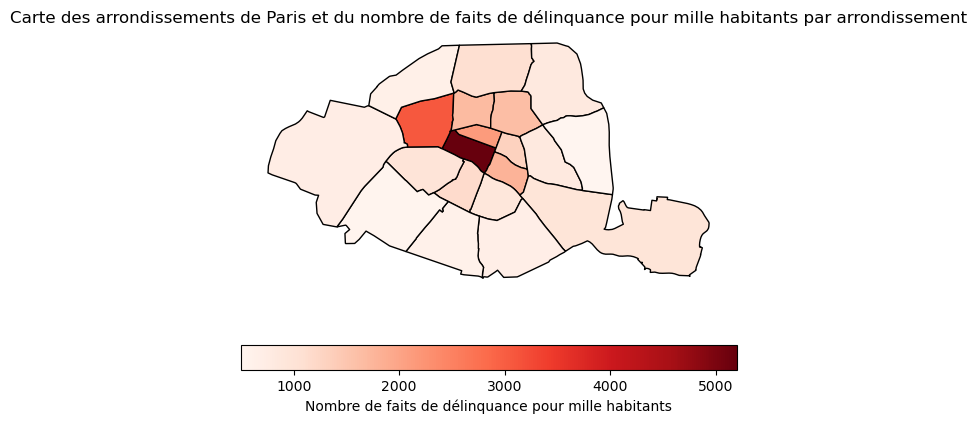

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from cartiflette import carti_download

# Importation de la carte des arrondissements de Paris
arr_borders = carti_download(
    crs=4326,
    values=["75"],
    borders="COMMUNE_ARRONDISSEMENT",
    vectorfile_format="geojson",
    filter_by="DEPARTEMENT",
    source="EXPRESS-COG-CARTO-TERRITOIRE",
    year=2022,
)

arr_borders = arr_borders.to_crs(2154)  

arr_borders['arrondissement'] = arr_borders['INSEE_COG'].str[-2:]  
arr_borders_sorted = arr_borders.sort_values(by='arrondissement')
arr_borders_sorted['tauxpourmille'] = delinquance_par_arrondissement['tauxpourmille'].values

carte = arr_borders_sorted.plot(
    column="tauxpourmille",  
    cmap="Reds",        
    legend=True,             
    edgecolor="black",       
    legend_kwds={"label": "Nombre de faits de délinquance pour mille habitants", "orientation": "horizontal"},
)

carte.set_axis_off()  
carte.set_title("Carte des arrondissements de Paris et du nombre de faits de délinquance pour mille habitants par arrondissement")

plt.show()

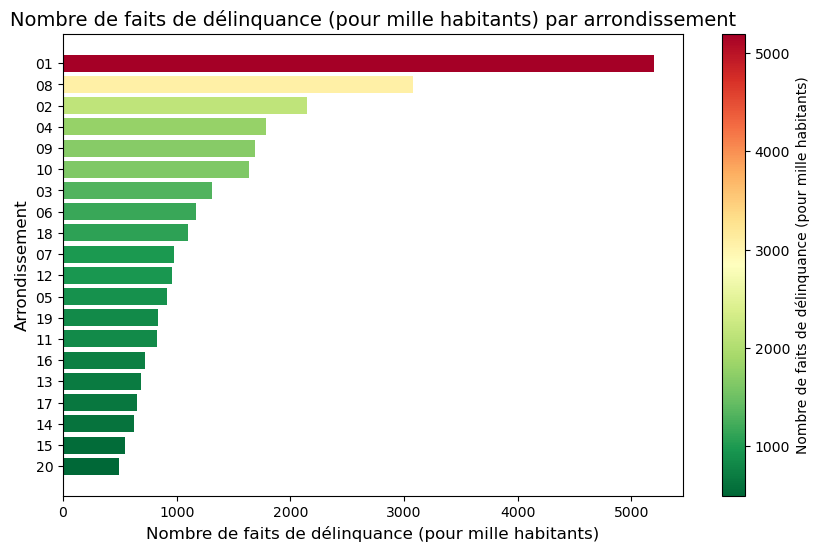

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Tri des données par taux de délinquance
delinquance_sorted = delinquance_par_arrondissement.sort_values(by='tauxpourmille')
norm = mcolors.Normalize(vmin=delinquance_sorted['tauxpourmille'].min(), 
                         vmax=delinquance_sorted['tauxpourmille'].max())
cmap = cm.RdYlGn_r

# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))
plt.barh(
    delinquance_sorted['arrondissement'], 
    delinquance_sorted['tauxpourmille'], 
    color=[cmap(norm(value)) for value in delinquance_sorted['tauxpourmille']]
)

plt.xlabel("Nombre de faits de délinquance (pour mille habitants)", fontsize=12)
plt.ylabel("Arrondissement", fontsize=12)
plt.title("Nombre de faits de délinquance (pour mille habitants) par arrondissement", fontsize=14)

# Ajout de la barre de couleur
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
fig.colorbar(sm, ax=ax, orientation='vertical', label="Nombre de faits de délinquance (pour mille habitants)")

plt.show()


## Distribution des types de délinquance par arrondissement

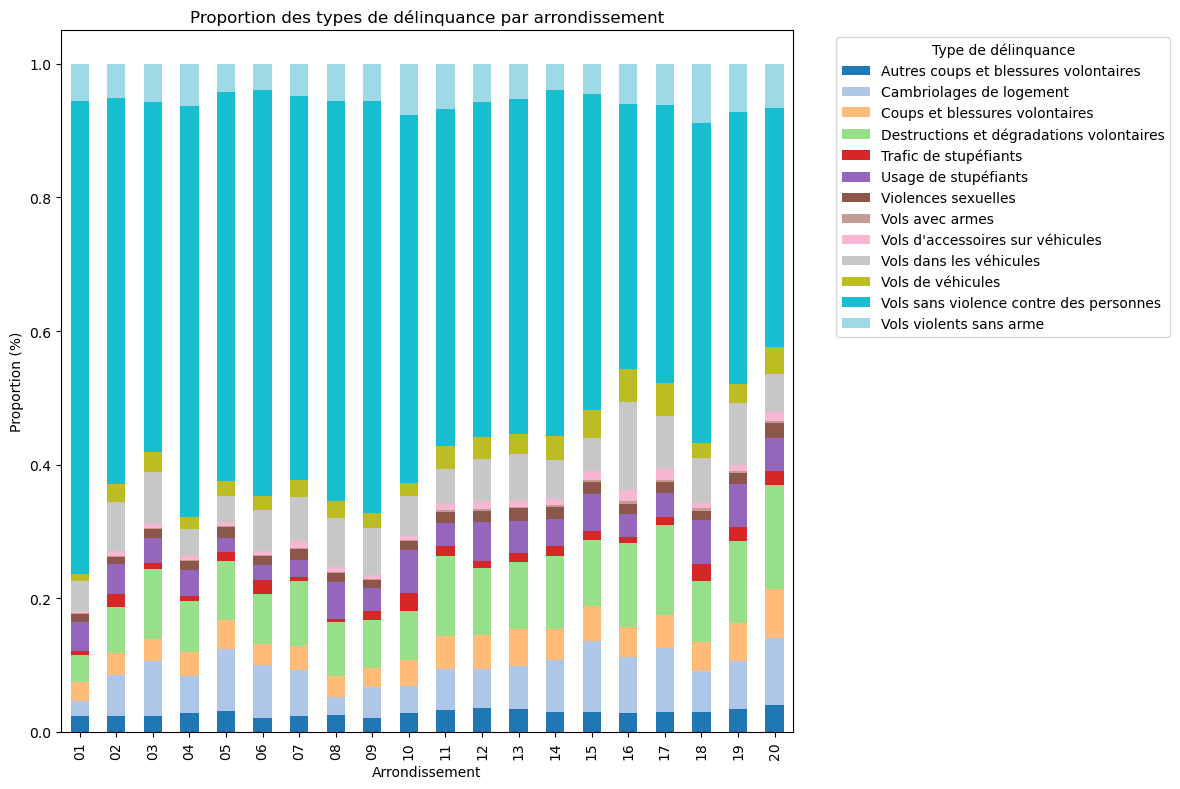

In [8]:

# Normalisation par arrondissement pour obtenir les proportions
df_delinquance_normalized = df_delinquance.copy()
df_delinquance_normalized['taux_normalise'] = df_delinquance_normalized.groupby('arrondissement')['tauxpourmille'].transform(lambda x: x / x.sum())

# Groupement des données par arrondissement et type de crime
grouped_data = df_delinquance_normalized.groupby(['arrondissement', 'classe'])['taux_normalise'].sum().unstack()

# Tracé du graphique 
ax = grouped_data.plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    colormap='tab20',
    title="Proportion des types de délinquance par arrondissement"
)

plt.xlabel("Arrondissement")
plt.ylabel("Proportion (%)")
plt.legend(title="Type de délinquance", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()